# 导入库包配置GPU

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas_profiling as ppf
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# # 设置中文和'-'负号显示问题
# from pylab import mpl
# mpl.rcParams['font.sans-serif'] = ['FangSong']  # 设置matplotlib可以显示汉语
# mpl.rcParams['axes.unicode_minus'] = True

# Preprocessing tools
import math
import time
import numpy as np
import pandas as pd

# DL/ML Algoirthm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings(action="ignore")

# 数据导入

In [2]:
cols = ["One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Rect", "Time_ns"]

train1_data = pd.read_csv("data/Train1.csv", header=None)
train2_data = pd.read_csv("data/Train2.csv", header=None)
train3_data = pd.read_csv("data/Train3.csv", header=None)
train_data = pd.read_csv("data/Train.csv", header=None)

test_data = pd.read_csv("data/Test.csv", header=None)
valid_data = pd.read_csv("data/Valid.csv", header=None)

train_data.columns = test_data.columns = valid_data.columns = cols

- train_data.shape：查看数据的形状
- train_data.head()：查看数据本身
- train_data.info()：数据集的简单描述， 总行数，空值或者数据类型等
- train_data.value_counts()：分类的时候用的多，查看类别的个数
- train_data.describe()：简单的统计性表述，最大值，最小，平均等
- train_data.corr(method='pearson')：查看列之间的相关性
- train_data.skew()：通过分析数据的高斯分布来确认数据的偏离情况

In [3]:
train_features = train_data.drop(['Rect', 'Time_ns'], axis=1)
train_labels = train_data.Rect
train_all = pd.concat([train_features, train_labels], axis=1, ignore_index=True, sort=False)
train_six_features = train_data.drop(['Two', 'Five', 'Rect', 'Time_ns'], axis=1)
train_two_features = pd.concat([train_data.Three, train_data.Four], axis=1, ignore_index=False, sort=False)

test_features = test_data.drop(['Rect', 'Time_ns'], axis=1)
test_labels = test_data.Rect
test_all = pd.concat([test_features, test_labels], axis=1, ignore_index=True, sort=False)
test_six_features = test_data.drop(['Two', 'Five', 'Rect', 'Time_ns'], axis=1)
test_two_features = pd.concat([test_data.Three, test_data.Four], axis=1, ignore_index=False, sort=False)

valid_features = valid_data.drop(['Rect', 'Time_ns'], axis=1)
valid_labels = valid_data.Rect
valid_all = pd.concat([valid_features, valid_labels], axis=1, ignore_index=True, sort=False)
valid_six_features = valid_data.drop(['Two', 'Five', 'Rect', 'Time_ns'], axis=1)
valid_two_features = pd.concat([valid_data.Three, valid_data.Four], axis=1, ignore_index=False, sort=False)

sEMG_all = pd.concat([train_all, test_all], axis=0, ignore_index=True, sort=False)

train_all.columns = test_all.columns = valid_all.columns = sEMG_all.columns = cols[:-1]
train_features, train_labels, train_all, sEMG_all, train_six_features, train_two_features

(      One  Two  Three  Four  Five  Six  Seven  Eight
 0      84  268    736   161    57  285     76    209
 1      90  262    717   147    54  292     78    216
 2      96  291    708   173    61  297     80    205
 3      96  361    719   164    58  302     80    208
 4      85  374    746   148    55  309     75    215
 ...   ...  ...    ...   ...   ...  ...    ...    ...
 8926  212  596    640   186    65  573    360    488
 8927  215  588    647   189    69  588    434    561
 8928  194  589    653   185    60  601    477    573
 8929  200  464    649   160    53  629    499    579
 8930  197  438    629   143    53  661    508    606
 
 [8931 rows x 8 columns],
 0       0.18
 1       0.19
 2       0.21
 3       0.22
 4       0.23
         ... 
 8926    0.29
 8927    0.30
 8928    0.31
 8929    0.32
 8930    0.33
 Name: Rect, Length: 8931, dtype: float64,
       One  Two  Three  Four  Five  Six  Seven  Eight  Rect
 0      84  268    736   161    57  285     76    209  0.18
 1     

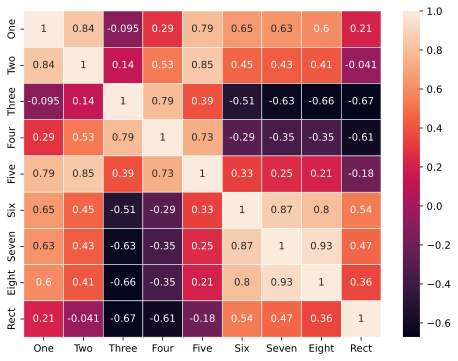

In [4]:
corr = train_all.corr()
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(corr, linewidths=.5, annot=True)

In [5]:
# 选择相关性较高的6个通道
CorrCols = ['Rect', 'Three', 'Four', 'Six', 'Seven', 'Eight', 'One']

In [6]:
from scipy.stats import skew
skew(train_all.Rect)  # 偏差程度

0.009526183901001566

# 模型选择

In [7]:
def try_different_method(model):
    model.fit(train_features, train_labels)
    score = model.score(test_features, test_labels)
    result = model.predict(test_features)
    
    return score

def try_different_method2(model):
    model.fit(train_features, train_labels)
    score = model.score(train_features, train_labels)
    result = model.predict(train_features)
    
    return score

def try_different_method3(model):
    model.fit(train_features, train_labels)
    score = model.score(valid_features, valid_labels)
    result = model.predict(valid_features)
    
    return score

def try_different_SixFeatures(model):
    model.fit(train_six_features, train_labels)
    score = model.score(test_six_features, test_labels)
    result = model.predict(test_six_features)
    
    return score

def try_different_TwoFeatures(model):
    model.fit(train_two_features, train_labels)
    score = model.score(test_two_features, test_labels)
    result = model.predict(test_two_features)
    
    return score

models = {}

####3.1决策树回归####
from sklearn import tree
models['DTR'] = tree.DecisionTreeRegressor()
####3.2线性回归####
from sklearn import linear_model
models['LR'] = linear_model.LinearRegression()
####3.3SVM回归####
from sklearn import svm
models['SVR'] = svm.SVR()
####3.4KNN回归####
from sklearn import neighbors
models['KNN'] = neighbors.KNeighborsRegressor()
####3.5随机森林回归####
from sklearn import ensemble
models['RF'] = ensemble.RandomForestRegressor()
####3.6Adaboost回归####
from sklearn import ensemble
models['AdaBoost'] = ensemble.AdaBoostRegressor()
####3.7GBRT回归####
from sklearn import ensemble
models['GBRT'] = ensemble.GradientBoostingRegressor()
####3.8Bagging回归####
from sklearn.ensemble import BaggingRegressor
models['Bagging'] = BaggingRegressor()
####3.9ExtraTree极端随机树回归####
from sklearn.tree import ExtraTreeRegressor
models['Extra'] = ExtraTreeRegressor()
####3.10XGBoost回归####
from xgboost import XGBRegressor
models['XGB'] = XGBRegressor()
####3.11LGBM回归####
from lightgbm import LGBMRegressor
models['LGB'] = LGBMRegressor()


scores = {}
for key in models:
    scores[key] = try_different_method(models[key])

scores

{'DTR': 0.6640412996659639,
 'LR': 0.6482428116719375,
 'SVR': 0.8112487760554079,
 'KNN': 0.7750371496980528,
 'RF': 0.8064085690124259,
 'AdaBoost': 0.6876149490724319,
 'GBRT': 0.7999514007150457,
 'Bagging': 0.7911495601052319,
 'Extra': 0.6006192366288142,
 'XGB': 0.7987759936439305,
 'LGB': 0.8066839445035114}

In [8]:
scores_order = sorted(scores.items(), key=lambda x:x[1], reverse=True)
scores_order

[('SVR', 0.8112487760554079),
 ('LGB', 0.8066839445035114),
 ('RF', 0.8064085690124259),
 ('GBRT', 0.7999514007150457),
 ('XGB', 0.7987759936439305),
 ('Bagging', 0.7911495601052319),
 ('KNN', 0.7750371496980528),
 ('AdaBoost', 0.6876149490724319),
 ('DTR', 0.6640412996659639),
 ('LR', 0.6482428116719375),
 ('Extra', 0.6006192366288142)]

In [43]:
def plot_model_results(model, name):
    model.fit(train_features, train_labels)
    
    score = model.score(train_features, train_labels)
    result = model.predict(train_features)
    plt.figure()
    plt.plot(np.arange(len(result)), train_labels,'go-',label='true value')
    plt.plot(np.arange(len(result)), result,'ro-',label='predict value')
    plt.title(f'{name + " train"} score: {score}')
    plt.legend()
    plt.show()
    
    score = model.score(test_features, test_labels)
    result = model.predict(test_features)
    plt.figure()
    plt.plot(np.arange(len(result)), test_labels,'go-',label='true value')
    plt.plot(np.arange(len(result)), result,'ro-',label='predict value')
    plt.title(f'{name + " test"} score: {score}')
    plt.legend()
    plt.show()
    
    score = model.score(valid_features, valid_labels)
    result = model.predict(valid_features)
    plt.figure()
    plt.plot(np.arange(len(result)), valid_labels,'go-',label='true value')
    plt.plot(np.arange(len(result)), result,'ro-',label='predict value')
    plt.title(f'{name + " valid"} score: {score}')
    plt.legend()
    plt.show()

# plot_model_results(models['SVR'], 'SVR')

# 选择SVR/LGB/Bagging/RF/GBRT/XGB 

## SVR
```python
svm.SVR(
    *,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    tol=0.001,
    C=1.0,
    epsilon=0.1,
    shrinking=True,
    cache_size=200,
    verbose=False,
    max_iter=-1,
)
```

In [15]:
model = svm.SVR(kernel='rbf',
                tol=1e-8,
                C=3.0201,
                epsilon=0.1021,
                shrinking=True)

model.fit(train_features, train_labels)
score = model.score(valid_features, valid_labels)

# score
# 最优解0.816364601413299

start = time.perf_counter()
result = model.predict(test_features[0])

end = time.perf_counter(np.array(test_features)[0])
print("time consuming : {:.4f}ms".format((end - start) * 1000))

# plot_model_results(model, 'SVR')

# best = 0
# best_C = 1
# i = 0.102
# while i < 0.1022:
#     model = svm.SVR(kernel='rbf',
#                     tol=1e-8,
#                     C=3.0201,
#                     epsilon=0.1021)
#     i = i + 0.0001
#     score = try_different_method(model)
#     if score > best:
#         best = score
#         best_C = i
    
# best, best_C

KeyError: 0

array([108., 350., 736., 189.,  75., 337., 182., 331.])

## LGB

```python

LGBMRegressor(
    boosting_type: str = 'gbdt',
    num_leaves: int = 31,
    max_depth: int = -1,
    learning_rate: float = 0.1,
    n_estimators: int = 100,
    subsample_for_bin: int = 200000,
    objective: Union[str, Callable, NoneType] = None,
    class_weight: Union[Dict, str, NoneType] = None,
    min_split_gain: float = 0.0,
    min_child_weight: float = 0.001,
    min_child_samples: int = 20,
    subsample: float = 1.0,
    subsample_freq: int = 0,
    colsample_bytree: float = 1.0,
    reg_alpha: float = 0.0,
    reg_lambda: float = 0.0,
    random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None,
    n_jobs: int = -1,
    silent: Union[bool, str] = 'warn',
    importance_type: str = 'split',
    **kwargs,
)
```

In [48]:
model = LGBMRegressor(boosting_type='goss',
                      num_leaves=26,
                      learning_rate=0.062,
                      n_estimators=130)

# score = try_different_method3(model)
# score

# 最优解：0.8134210550502501

# plot_model_results(model, 'LGBR')

# best = 0
# best_C = 1
# i = 100
# while i < 150:
#     model =  LGBMRegressor(boosting_type='goss',
#                            num_leaves=26,
#                            learning_rate=0.0620,
#                            n_estimators=130)
#     i = i + 1
#     score = try_different_method(model)
#     if score > best:
#         best = score
#         best_C = i
    
# best, best_C

## Bagging
```python
BaggingRegressor(
    base_estimator=None,
    n_estimators=10,
    *,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    oob_score=False,
    warm_start=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
)
```

In [50]:
model =  BaggingRegressor(n_estimators=143)

score = try_different_method3(model)
score
# 最优解：0.8096000435675867

# plot_model_results(model, 'BR')
# score

# i = 100
# best = 0
# best_C = i

# while i < 160:
#     model =  BaggingRegressor(n_estimators=i)
    
#     i = i + 1
#     score = try_different_method(model)
#     if score > best:
#         best = score
#         best_C = i
    
# best, best_C

0.8026518536067003

## RF
```python
ensemble.RandomForestRegressor(
    n_estimators=100,
    *,
    criterion='mse',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)
```

In [53]:
model =  ensemble.RandomForestRegressor(n_estimators=85)

score = try_different_method(model)
score
# 最优解：0.8066238278021981

# plot_model_results(model, 'RFR')
# score

# best = 0
# best_C = 1
# i = 20
# while i < 150:
#     model =  ensemble.RandomForestRegressor(
#                         n_estimators=85)
#     i = i + 1
#     score = try_different_method(model)
#     if score > best:
#         best = score
#         best_C = i
    
# best, best_C

0.8060978691436577

## GBRT
```python
ensemble.GradientBoostingRegressor(
    *,
    loss='ls',
    learning_rate=0.1,
    n_estimators=100,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    init=None,
    random_state=None,
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    presort='deprecated',
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0,
)
```

In [54]:
model =  ensemble.GradientBoostingRegressor(loss='ls',
                                            learning_rate=0.6021,
                                            n_estimators=89)

# score = try_different_method(model)
# score
# 最优解：0.8004695927552139

# plot_model_results(model, 'GBR')


# i = 80
# best = 0
# best_C = i

# while i < 100:
#     model =  ensemble.GradientBoostingRegressor(loss='ls',
#                                                 learning_rate=0.6021,
#                                                 n_estimators=89)
#     i = i + 1
#     score = try_different_method(model)
#     if score > best:
#         best = score
#         best_C = i
    
# best, best_C

## XGB
```python
XGBRegressor(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror',
    **kwargs: Any,
) -> None
```

In [56]:
model =  XGBRegressor(n_estimators=16, learning_rate=0.2051)

# score = try_different_method(model)
# score
# 最优解：0.8202051415235915

# plot_model_results(model, 'XR')


# i = 0.2
# best = 0
# best_C = i

# while i < 0.23:
#     model =  XGBRegressor(n_estimators=16, learning_rate=0.2051)
    
#     i = i + 0.0001
#     score = try_different_method(model)
#     if score > best:
#         best = score
#         best_C = i
    
# best, best_C

## 其他

In [28]:
model = tree.DecisionTreeRegressor()

model.fit(train_features, train_labels)
score = model.score(test_features, test_labels)

# score
# 最优解0.816364601413299

start = time.perf_counter()
result = model.predict(test_features)

end = time.perf_counter()
print("time consuming : {:.4f}ms".format((end - start) * 1000))
print(score)

time consuming : 1.2995ms
0.6408482606402816


# 模型融合

In [14]:
models = {}
models['SVR'] = svm.SVR(kernel='rbf', tol=1e-8, C=3.0201, epsilon=0.1021, shrinking=True)
models['LGB'] = LGBMRegressor(boosting_type='goss', num_leaves=26, learning_rate=0.062, n_estimators=130)
models['Bagging'] = BaggingRegressor(n_estimators=143)
models['RF'] = ensemble.RandomForestRegressor(n_estimators=85)
models['GBRT'] = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=0.6021, n_estimators=89)
models['XGB'] = XGBRegressor(n_estimators=16, learning_rate=0.2051)

In [13]:
train_results = np.zeros((train_features.shape[0], len(models)))
test_results = np.zeros((test_features.shape[0], len(models)))
valid_results = np.zeros((valid_features.shape[0], len(models)))


idx = 0
for model in models:
    models[model].fit(train_features, train_labels)
    train_results[:, idx] = models[model].predict(train_features)
    test_results[:, idx] = models[model].predict(test_features)
    valid_results[:, idx] = models[model].predict(valid_features)
    idx += 1

train_results, test_results, valid_results

(array([[0.43085063, 0.30477173, 0.23167832, 0.20976471, 0.28845479,
         0.37974083],
        [0.44880923, 0.30763618, 0.25167832, 0.22811765, 0.26067798,
         0.37974083],
        [0.44601176, 0.31969189, 0.23363636, 0.23588235, 0.27522198,
         0.33478057],
        ...,
        [0.27416195, 0.27762241, 0.3065035 , 0.28764706, 0.1957659 ,
         0.25217813],
        [0.33256748, 0.28362576, 0.30265734, 0.28717647, 0.23436033,
         0.25018883],
        [0.34077732, 0.27405009, 0.29818182, 0.28329412, 0.28078823,
         0.29625681]]),
 array([[0.32102138, 0.39810778, 0.46286713, 0.42988235, 0.49197519,
         0.41710743],
        [0.31598836, 0.41696216, 0.51230769, 0.50329412, 0.49892752,
         0.43328741],
        [0.25276803, 0.37851528, 0.31643357, 0.25894118, 0.39213947,
         0.33069032],
        ...,
        [0.26341001, 0.26353859, 0.27      , 0.26517647, 0.30275246,
         0.2670275 ],
        [0.27854299, 0.26846458, 0.26657343, 0.26176471, 0.255

In [14]:
train_labels, test_labels

(0       0.18
 1       0.19
 2       0.21
 3       0.22
 4       0.23
         ... 
 8926    0.29
 8927    0.30
 8928    0.31
 8929    0.32
 8930    0.33
 Name: Rect, Length: 8931, dtype: float64,
 0       0.19
 1       0.20
 2       0.21
 3       0.22
 4       0.23
         ... 
 2972    0.29
 2973    0.29
 2974    0.31
 2975    0.32
 2976    0.32
 Name: Rect, Length: 2977, dtype: float64)

In [14]:
import torch
import torch.nn as nn
import torch.utils.data as tud

gpu = torch.cuda.is_available()
device = 'cpu'

train_results = torch.tensor(train_results, dtype=torch.float32, device=device)
test_results = torch.tensor(test_results, dtype=torch.float32, device=device)
valid_results = torch.tensor(valid_results, dtype=torch.float32, device=device)
train_results, test_results, valid_results

(tensor([[0.4309, 0.3048, 0.2359, 0.2236, 0.2885, 0.3797],
         [0.4488, 0.3076, 0.2327, 0.2387, 0.2607, 0.3797],
         [0.4460, 0.3197, 0.2351, 0.2171, 0.2752, 0.3348],
         ...,
         [0.2742, 0.2776, 0.3016, 0.3016, 0.1958, 0.2522],
         [0.3326, 0.2836, 0.3024, 0.2952, 0.2344, 0.2502],
         [0.3408, 0.2741, 0.3015, 0.2882, 0.2808, 0.2963]]),
 tensor([[0.3210, 0.3981, 0.4680, 0.4182, 0.4920, 0.4171],
         [0.3160, 0.4170, 0.5047, 0.4598, 0.4989, 0.4333],
         [0.2528, 0.3785, 0.2811, 0.2862, 0.3921, 0.3307],
         ...,
         [0.2634, 0.2635, 0.2763, 0.2622, 0.3028, 0.2670],
         [0.2785, 0.2685, 0.2700, 0.2673, 0.2557, 0.2920],
         [0.2949, 0.3091, 0.2736, 0.2694, 0.3104, 0.3143]]),
 tensor([[0.3435, 0.3384, 0.3585, 0.3507, 0.3517, 0.3079],
         [0.3640, 0.3686, 0.3906, 0.3864, 0.3279, 0.3043],
         [0.4421, 0.4230, 0.3944, 0.3584, 0.3753, 0.4143],
         ...,
         [0.3846, 0.3632, 0.3902, 0.3991, 0.3484, 0.4002],
         [

In [20]:
class MyR2Loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, YTrue, YPre):
        u = ((YTrue - YPre) ** 2).sum()
        v = ((YTrue - YTrue.mean()) ** 2).sum()
        return u / v - 1


class HbModel(nn.Module):
    def __init__(self):
        super(HbModel, self).__init__()
        
        self.InputNum = 6
        self.OutputNum = 1
        
        self.linear = nn.Linear(self.InputNum, self.OutputNum, bias=True)
        
        self.loss_func = MyR2Loss()
        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=0.001)

    def forward(self, x):
        y = self.linear(x)
        
        return y
        
    def initialize(self):
        nn.init.normal_(self.linear.weight.data, std=np.sqrt(1/self.InputNum))


train_DataLoader = tud.DataLoader(tud.TensorDataset(train_results, torch.tensor(train_labels, device=device)) , batch_size=8, shuffle=True, num_workers=2, drop_last=True)
test_DataLoader = tud.DataLoader(tud.TensorDataset(test_results, torch.tensor(test_labels, device=device)) , batch_size=8, shuffle=False, num_workers=2, drop_last=True)

In [21]:
def train_step(model, features, labels):
    
    # 训练模式，dropout层发生作用
    model.train()
    
    # 梯度清零
    model.optimizer.zero_grad()
    
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(labels, predictions)

    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()

    return loss.item()


@torch.no_grad()
def valid_step(model, features, labels):
    
    # 预测模式，dropout层不发生作用
    model.eval()
    
    predictions = model(features)
    loss = model.loss_func(labels, predictions)
    
    return loss.item()


NNModel = HbModel()
NNModel.initialize()
NNModel.to(device)
# 测试train_step效果
features, labels = next(iter(train_DataLoader))
train_step(NNModel, features, labels), valid_step(NNModel, features, labels)

(252.0344369045696, 250.35209110775736)

In [22]:
from datetime import datetime

def train_model(model, epochs, dl_train, dl_valid, log_step_freq):
    BestScore = float('inf')
    BestModel = []
    
    dfhistory = pd.DataFrame(columns = ["epoch", "loss", "val_loss"]) 
    print("Start Training...")
    nowtime = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("%s" % nowtime)

    for epoch in range(1, epochs + 1):  

        # 训练循环
        loss_sum = 0.0
        step = 1

        for step, (features, labels) in enumerate(dl_train, 1):

            loss = train_step(model, features, labels)

            # 打印batch级别日志
            loss_sum += loss
            if step % log_step_freq == 0:   
                print(("[step = %d] loss: %.3f") %
                      (step, loss_sum / step))

        # 验证循环
        val_loss_sum = 0.0
        val_step = 1

        for val_step, (features, labels) in enumerate(dl_valid, 1):

            val_loss = valid_step(model, features, labels)
            
            val_loss_sum += val_loss
            
            if val_loss < BestScore:
                BestScore = val_loss
                BestModel = model

        # 记录日志
        info = (epoch, loss_sum / step, val_loss_sum / val_step)
        dfhistory.loc[epoch - 1] = info
        
        # 打印epoch级别日志
        print(("\nEPOCH = %d, loss = %.3f, val_loss = %.3f, ") % info)
        nowtime = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n" + "%s" % nowtime)

    print('Finished Training...')
    return dfhistory, BestModel, BestScore

epochs = 10
dfhistory, BestModel, BestScore = train_model(NNModel, epochs, train_DataLoader, test_DataLoader, log_step_freq = 100)

Start Training...
2022-02-18 11:21:38
[step = 100] loss: 141.982
[step = 200] loss: 108.830
[step = 300] loss: 83.267
[step = 400] loss: 67.022
[step = 500] loss: 55.838
[step = 600] loss: 48.163
[step = 700] loss: 42.586
[step = 800] loss: 38.329
[step = 900] loss: 35.050
[step = 1000] loss: 32.451
[step = 1100] loss: 30.289

EPOCH = 1, loss = 29.967, val_loss = 982.218, 

2022-02-18 11:21:40
[step = 100] loss: 8.424
[step = 200] loss: 8.362
[step = 300] loss: 8.371
[step = 400] loss: 8.460
[step = 500] loss: 8.457
[step = 600] loss: 8.491
[step = 700] loss: 8.464
[step = 800] loss: 8.426
[step = 900] loss: 8.440
[step = 1000] loss: 8.428
[step = 1100] loss: 8.416

EPOCH = 2, loss = 8.411, val_loss = 1017.022, 

2022-02-18 11:21:43
[step = 100] loss: 8.125
[step = 200] loss: 8.724
[step = 300] loss: 8.626
[step = 400] loss: 8.637
[step = 500] loss: 8.573
[step = 600] loss: 8.507
[step = 700] loss: 8.475
[step = 800] loss: 8.499
[step = 900] loss: 8.547
[step = 1000] loss: 8.498
[step 

In [23]:
NNModel(train_results)

tensor([[0.4384],
        [0.4336],
        [0.4432],
        ...,
        [0.4270],
        [0.4455],
        [0.4582]], grad_fn=<AddmmBackward0>)

In [24]:
NNModel.linear.weight

Parameter containing:
tensor([[ 0.1283, -0.2392,  0.4327, -0.3162,  0.2891, -0.1371]],
       requires_grad=True)

## 网格遍历权重

In [4]:
def R2Score(YTrue, YPre):
        u = ((YTrue - YPre) ** 2).sum()
        v = ((YTrue - YTrue.mean()) ** 2).sum()
        return 1 - u / v

In [16]:
best_weight = [42, 4, 14, 11, 9, 20]
best_value = 0.8339

# test_labels = torch.tensor(test_labels)

# for i in range(13, 101, 1):
#     for j in range(0, 101, 1):
#         if i + j > 100:
#             break
#         for k in range(0, 101, 1):
#             if i + j + k > 100:
#                 break
#             for l in range(0, 101, 1):
#                 if i + j + k + l > 100:
#                     break
#                 for m in range(0, 101, 1):
#                     if i + j + k + l + m > 100:
#                         break
#                     w = torch.tensor([i, j, k, l, m, 100-i-j-k-l-m], dtype=torch.float32)
#                     test_re = test_results @ w / 100
#                     R2 = R2Score(test_labels, test_re)
#                     if R2 > best_value:
#                         best_value = R2
#                         best_weight = w
        
#     print(i, best_value, best_weight)


In [5]:
import torch

best_weight = torch.tensor([0.42, 0.04, 0.14, 0.11, 0.09, 0.20])

In [6]:
train_labels = torch.tensor(train_labels)
train_results = torch.tensor(train_results, dtype=torch.float32)

train_re = train_results @ best_weight
train_score = R2Score(train_labels, train_re)
train_score

NameError: name 'train_results' is not defined

In [19]:
test_labels = torch.tensor(test_labels)
test_results = torch.tensor(test_results, dtype=torch.float32)

test_re = test_results @ best_weight
test_score = R2Score(test_labels, test_re)
test_score

tensor(0.8338, dtype=torch.float64)

In [20]:
valid_labels = torch.tensor(valid_labels)
valid_results = torch.tensor(valid_results, dtype=torch.float32)

valid_re = valid_results @ best_weight
valid_score = R2Score(valid_labels, valid_re)
valid_score

tensor(0.8275, dtype=torch.float64)

# 保存模型

In [21]:
models

{'SVR': SVR(C=3.0201, epsilon=0.1021, tol=1e-08),
 'LGB': LGBMRegressor(boosting_type='goss', learning_rate=0.062, n_estimators=130,
               num_leaves=26),
 'Bagging': BaggingRegressor(n_estimators=143),
 'RF': RandomForestRegressor(n_estimators=85),
 'GBRT': GradientBoostingRegressor(learning_rate=0.6021, loss='ls', n_estimators=89),
 'XGB': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2051, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=16, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)}

In [48]:
import joblib

joblib.dump(models, 'sEMGML.pkl')

['sEMGML.pkl']

# 读取模型

In [29]:
import joblib

models = joblib.load('models/sEMGML.pkl')

In [30]:
train_results = np.zeros((train_features.shape[0], len(models)))
test_results = np.zeros((test_features.shape[0], len(models)))
valid_results = np.zeros((valid_features.shape[0], len(models)))


idx = 0
for model in models:
    print(model)
    train_results[:, idx] = models[model].predict(train_features)
    test_results[:, idx] = models[model].predict(test_features)
    valid_results[:, idx] = models[model].predict(valid_features)
    idx += 1

train_results, test_results, valid_results

SVR
LGB
Bagging
RF
GBRT
XGB


(array([[0.43085063, 0.30477173, 0.22223776, 0.22317647, 0.28845479,
         0.37974083],
        [0.44880923, 0.30763618, 0.22979021, 0.22835294, 0.26067798,
         0.37974083],
        [0.44601176, 0.31969189, 0.2441958 , 0.24035294, 0.27522198,
         0.33478057],
        ...,
        [0.27416195, 0.27762241, 0.29944056, 0.29235294, 0.1957659 ,
         0.25217813],
        [0.33256748, 0.28362576, 0.30496503, 0.29682353, 0.23436033,
         0.25018883],
        [0.34077732, 0.27405009, 0.30132867, 0.28470588, 0.28078823,
         0.29625681]]),
 array([[0.32102138, 0.39810778, 0.42202797, 0.34352941, 0.49197519,
         0.41710743],
        [0.31598836, 0.41696216, 0.45503497, 0.37811765, 0.49892752,
         0.43328741],
        [0.25276803, 0.37851528, 0.28972028, 0.27741176, 0.39213947,
         0.33069032],
        ...,
        [0.26341001, 0.26353859, 0.25391608, 0.27435294, 0.30275246,
         0.2670275 ],
        [0.27854299, 0.26846458, 0.26195804, 0.26423529, 0.255

In [31]:
def R2Score(YTrue, YPre):
        u = ((YTrue - YPre) ** 2).sum()
        v = ((YTrue - YTrue.mean()) ** 2).sum()
        return 1 - u / v

In [32]:
w = np.array([42, 4, 14, 11, 9, 20])
test_re = train_results @ w / 100
R2 = R2Score(train_labels, test_re)

In [33]:
R2

0.934382825970081

In [65]:
plt.figure()
plt.plot(np.arange(len(test_re)), train_labels,'go-',label='True Value')
plt.plot(np.arange(len(test_re)), test_re,'ro-',label='Predict Value')
# plt.title(f'{name} score: {score}')
plt.xlabel = "Samples"
plt.ylabel = "Angle of Rotation"
plt.legend()
plt.show()